## Assignment 3
Paula Gaviria
03/04/2021
Winter 2021

1. Using computational methods, evaluate Horkheimer and Adorno's claim that "Culture today is infecting everything with sameness" (2002 [1947]: 94) as it pertains to popular music in the Billboard Hot 100. Is there evidence of such homogenization in the popular music industry? You should make your case using the data provided in music_df.csv (which we worked with in class on Thursday, 2/18), but are welcome to incorporate any additional digital data that you think would help make your case.

*To test if there is there is homogenization in the music industry I used unsupervised machine learning with the numerical variables in the music.csv and created a pipeline to conduct a principal component analysis (PCA), with 7 clusters. Each cluster represents a decade, in this case the decade is the variable that suggests the number of clusters since I wanted to test if the different music metrics and the word use and counts in the songs were related to a specific decade or not, and if they were differences between each decade. I also conducted a lemma count for the lyrics of each decade to see if the words that were used the most in the songs varied from one decade to another. In both analysis I found no evidence of heterogenization neither in the lyrics , the sound metrics and word use. The 20 top words for the seven decades were all the same, the only thing that vary was the number of times used in each decade. They all used the words “love”, “baby “, “know”, “get”, "like”, etc. It seemed as if a formula was being used to write the lyrics for popular songs, or for songs to be popular. The PCA analysis is more subjective and therefore harder to interpret, but when looking at the plot it was very clear that the data points from the predicted decade and the actual decade were not clearly separated in the seven clusters. The clusters were composed of values from every decade and there was no clear separation amongst the true values in one or another cluster. The only cluster and true values that seemed to be a bit more well defined was the 1950s, since it did not overlap as much with other clusters, and the predicted cluster did not have as many true values from other decades. If we look at the plot we also see that it seems as if there were only two larger clusters composed of the smaller created clusters, this might indicate a difference in the songs that is not defined by the decade but by some other unknown variables.*

- **Download libraries.**

In [1]:
import librosa
import librosa.display
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf
from collections import Counter
import nltk
import string
import os
from gensim import corpora, models
import music
import spacy
import wordcloud
import wordtodigits

In [2]:
path = os.getcwd()
music_df = pd.read_csv('music_df.csv')

In [3]:
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20' + x if (x == '10s') or (x == '00s') else '19'+x)

In [4]:
music_df.dtypes

lyrics                   object
num_syllables           float64
pos                     float64
year                      int64
fog_index               float64
flesch_index            float64
num_words                 int64
num_lines                 int64
title                    object
f_k_grade               float64
artist                   object
difficult_words           int64
num_dupes                 int64
neg                     float64
neu                     float64
compound                float64
id                       object
danceability            float64
energy                  float64
key                       int64
loudness                float64
mode                      int64
speechiness             float64
acousticness            float64
instrumentalness        float64
liveness                float64
valence                 float64
tempo                   float64
duration_ms             float64
time_signature            int64
uri                      object
analysis

- **Drop object type variables to perform k-means clustering.**

In [5]:
music_clusters = music_df.drop(['lyrics', 'title','artist','id', 'uri', 'analysis_url', 'artist_with_features',
                               'image','Gender', 'cluster'], axis=1)
music_clusters

,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,f_k_grade,difficult_words,num_dupes,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year_bin
0,189.0,0.199,1950,5.2,88.74,145,17,2.9,13,10,...,1,0.0325,0.90300,0.000001,0.1070,0.339,86.198,207573.0,3,1950s
1,270.9,0.224,1950,4.4,82.31,189,31,3.3,40,32,...,1,0.0389,0.93900,0.000000,0.1600,0.181,170.869,198027.0,5,1950s
2,174.6,0.351,1950,5.2,88.74,138,16,2.9,5,10,...,1,0.0276,0.78400,0.000671,0.1160,0.294,86.335,182733.0,3,1950s
3,135.9,0.231,1950,4.4,99.23,117,18,0.9,10,3,...,1,0.0357,0.78000,0.000000,0.1260,0.474,82.184,158000.0,3,1950s
4,46.8,0.079,1950,6.0,69.79,32,3,6.0,9,0,...,1,0.0408,0.80100,0.000000,0.1580,0.633,123.314,190933.0,4,1950s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,570.6,0.120,2015,5.6,96.18,469,51,2.1,42,13,...,1,0.1660,0.08440,0.000000,0.0730,0.340,123.909,199453.0,4,2010s
4024,169.2,0.184,2015,4.0,91.78,126,22,1.7,15,8,...,0,0.0369,0.00821,0.001400,0.0829,0.450,119.993,208133.0,4,2010s
4025,217.8,0.067,2015,4.8,106.67,193,26,0.1,16,21,...,0,0.0322,0.02510,0.000000,0.5610,0.533,139.988,214726.0,4,2010s
4026,399.6,0.026,2015,4.0,83.32,296,52,2.9,31,34,...,1,0.0353,0.85900,0.000000,0.1150,0.370,120.001,226600.0,4,2010s


- **Create matrix for unsupervised clustering.**

In [6]:
features = ['num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'f_k_grade', 'difficult_words', 'num_dupes',
       'neg', 'neu', 'compound', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']

x = music_clusters.loc[:, features].values
y = music_clusters.loc[:, ['year_bin']].values

x = StandardScaler().fit_transform(x)

In [7]:
y_decade = y.ravel()
decade_name = np.array(y_decade)
decade_name

array(['1950s', '1950s', '1950s', ..., '2010s', '2010s', '2010s'],
      dtype=object)

*Each number represents a decade 0 = 1950s, 1 = 1960s, 2 =1970s and so on.*

In [8]:
label_encoder = LabelEncoder()
decade_labels = label_encoder.fit_transform(decade_name)
decade_labels[0:]

array([0, 0, 0, ..., 6, 6, 6])

- **Select number of clusters by number of different decades.**

In [9]:
label_encoder.classes_
n_clusters = len(label_encoder.classes_)

- **Create pipeline.**

In [10]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [11]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

In [12]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [13]:
pipe.fit(x)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=7, n_init=50, n_jobs=None,
                                         precomp

In [14]:
preprocessed_data = pipe["preprocessor"].transform(x)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.4830661386108402

In [15]:
true_label = label_encoder.inverse_transform(decade_labels)
true_label

array(['1950s', '1950s', '1950s', ..., '2010s', '2010s', '2010s'],
      dtype=object)

In [16]:
adjusted_rand_score(decade_labels, predicted_labels)

0.06260619087698861

In [17]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(x),
    columns=["component_1", "component_2"],
)

In [18]:
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(decade_labels)

- **Create scatter plot with 2 PCA graph with 7 clusters.**

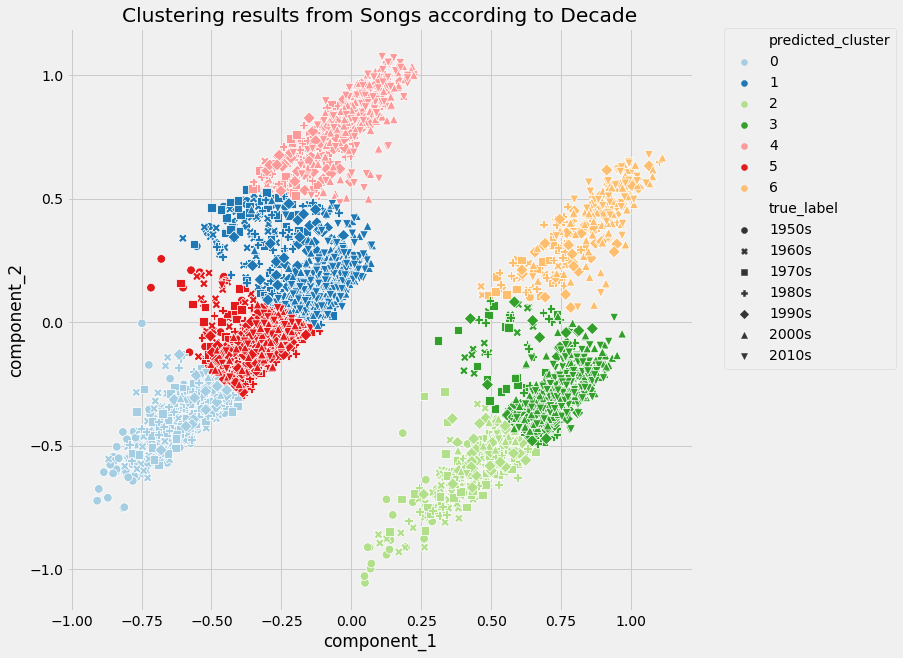

In [19]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10, 10))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=75,
    data=pcadf,
    hue= 'predicted_cluster',
    style= 'true_label' ,
    palette="Paired",
)
scat.set_title(
    "Clustering results from Songs according to Decade"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*The performance of the pipeline was not good. Not only do the clusters overlapped but the values for the predicted cluster are composed of music that belongs to all the seven decades, there seems to be no clear defenition between one decade and the other and the top hits from each one. The predicted decade and the true decade are not correctly identified by the 2 component PCA.* 

- Sources: https://realpython.com/k-means-clustering-python/

- **Identify popular word use in each decade in songs.**

In [20]:
music_50 = music_df[music_df['year_bin'] =='1950s']['lyrics']
music_60 = music_df[music_df['year_bin'] =='1960s']['lyrics']
music_70 = music_df[music_df['year_bin'] =='1970s']['lyrics']
music_80 = music_df[music_df['year_bin'] =='1980s']['lyrics']
music_90 = music_df[music_df['year_bin'] =='1990s']['lyrics']
music_00 = music_df[music_df['year_bin'] =='2000s']['lyrics']
music_10 = music_df[music_df['year_bin'] =='2010s']['lyrics']

In [21]:
text50 = ''.join(music_50)
text60 = ''.join(music_60)
text70 = ''.join(music_70)
text80 = ''.join(music_80)
text90 = ''.join(music_90)
text00 = ''.join(music_00)
text10 = ''.join(music_10)

In [22]:
stop = nltk.corpus.stopwords.words('english') + list(string.punctuation) + ["'s", "n't", "'ll","'m","'re", "oh",
                                                                           "na", "'ve", "ca", "ai", "'", "...", ",",
                                                                           "as", "get", "like", "let", "go"]
def get_lemmas(text):
    
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def plot_top_lemmas(text, data_description, n=20 ):
    
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]

    nltk.FreqDist(lemmas).plot(n, title='Top 20 Lemmas Overall for ' + data_description);
    return

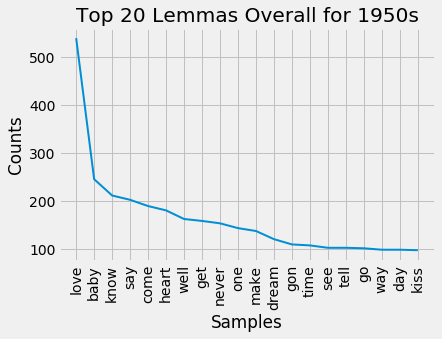

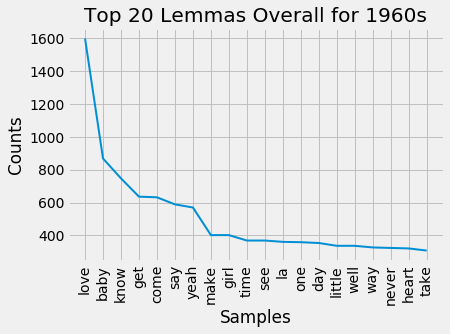

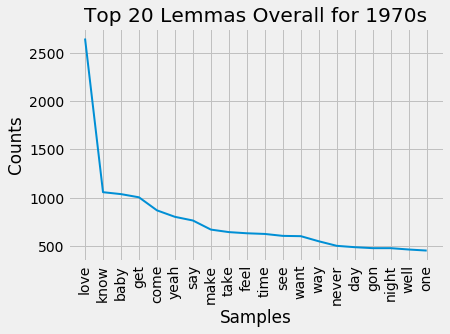

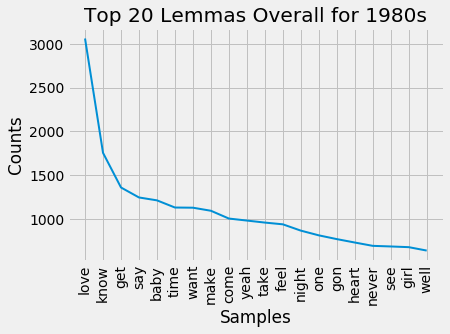

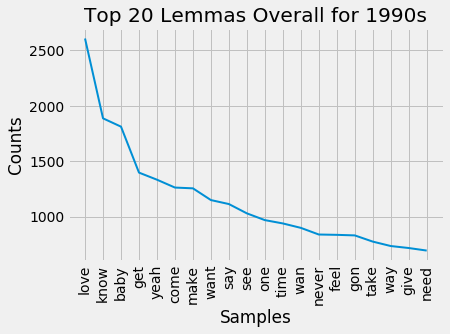

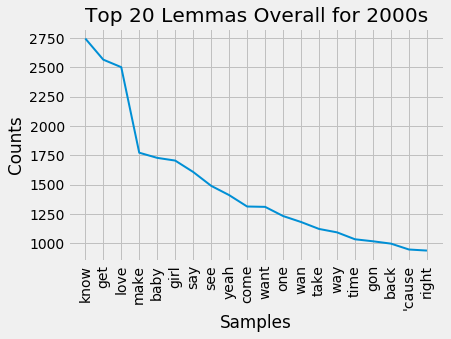

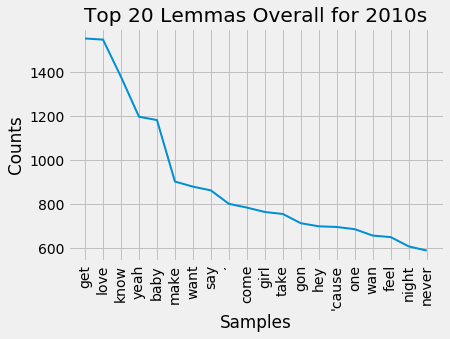

In [23]:
plot_top_lemmas(text50, "1950s", n=20)
plot_top_lemmas(text60, "1960s", n=20)
plot_top_lemmas(text70, "1970s", n=20)
plot_top_lemmas(text80, "1980s", n=20)
plot_top_lemmas(text90, "1990s", n=20)
plot_top_lemmas(text00, "2000s", n=20)
plot_top_lemmas(text10, "2010s", n=20)

2. Develop a theory about what drives the homogenization (or heterogenization) you identified in (1). Draw on social science theory (from this class and/or others) to make your interpretation (for instance, the Frith 1996, Du Gay et al. 2013, and Manovich 2020 readings might be useful). Cite at least 4 peer-reviewed sources in order to make your case.

*As Du Gay et al. (2013) say "belonging to a culture provides us to access to...shared frameworks...of meaning which we use to place and understand things, to make sense of the world, to formulate ideas and to communicate or exchange ideas and meanings about it". I believe music is one of these frameworks, it allows us to make sense of the world by expressing these sensations in compositions and lyrics, at the same time that it helps us understand what is happening, give a meaning to the cultural world. There are two important legising relationships in music, the composition and the lyrics. They both evoke feelings in the individual and produce sensations in the listener. "The crucial link between identity formation and..music lies in the specific semiotic character of these activities which make them particularly affective and direct ways of knowing" (Turino, 1999). The composition by itself is capable of provoking feelings of euphoria, high energy/high valence, or feelings of sadness, low valence, or even feelings of anger, high loudness/low valence. The lyrics can also produce these emotions but without a rhythm they are less like a song and more like words or a monolouge. As Firth (1996) says "music imposes on words its own way of reading, through its own production of rhytmic stress, its own power over how syllables are sounded, a power which may determine...what those words mean...it departs from its "natural" linguistic ryhthm."So it is the relationship between these two legisings, the composition and the lyrics of the song, that work together as a representation of the cultural movements within a decade and between the decades.*  


*I believe there is a strong relationship between what is being listened to and what is being composed and produced, and the social, economic, technical, and political panorama, since they are "part of the our cultural universe" (Du Gay et. al, 2013). Therefore the social, economic, technical, and political changes will have an impact on the music being produced and consumed, and how it is produced. The music is a reflection of society and society is shaped by the music being produced. Music, "is a key resource for realizing personal and collective identities which in turn, are crucial for social, political and economic participation."(Turino, 1999). I believe there will be more similarities or homogenization in the composition because there is a certain range of sounds that we find more pleasant or easy to listen to, or a composition of notes that provokes certain emotions that can not be changed too much. I expect to find more differences in the lyrics, more heterogenization in what is being expressed with the words in a song from decade to decade.*


*Whereas to the homogenization we see in the example above I believe it is due to the fact that we are only using data from the Billboard Hot 100, so it is a small data set that only includes those songs that were the most popular in the United States, or english speaking countries, according to their specific measurments and therefore might be biased. They seem to select "pop" songs according to a specific melody and with lyrics that are similar as well. A study on popular western music (pop music) from the 1950s to 2010, cited in Manovich (2020) found that "many sound parameters of popular music did not change during this period...it became less diverse during the 55 year period being studied." They are not taking into account other music platforms nor songs from other countries or in other languages, which seems to be leading to a type of song whose popularity depends on a type of formula (lyrics + music metrics) that appeals to a large audience and therefore the high ranking. I believe they are songs that attract the masses because they are easy to listen to, both the words used and the melody. They are songs that "follow the rules", the lyrics are not controversial and neither is the metric. They are produced for the masses so they have to be easy to listen to, simple songs, predictable, and easy to follow songs.*

3. What legisign relationship(s) should exist if your theory explains the observed pattern? How can you computationally test if this legisign relationship exists? Explain in 100+ words.

*I believe there are two important legising relationships in music, the composition and the lyrics. They both evoke feelings in the individual, they produce sensations in the listener and represent the social, cultural economic and political panorama. The melody, a __Rhematic Symbolic Legisign__, composed of notes and the pace of the notes, is always relational, there is no music with only one note.I believe the melody that makes music popular is usually the one that is easy to listen to, therefore I would expect it to follow a certain composition that has little variation from decade to decade. Whereas I would expect to find variations in the composition of the music that is not popular, between decades and within the same decade. There should be little to no change in the tempo of music, since it is the speed or pace of a song and most songs follow common tempo markings, and they are approximations of a specific metric. Therefore it is unlikely that the tempo will be extremely different from one decade to another or that the popularity or unpopularity of the tempo in songs varies a lot. The way the mode interacts with the tempo may vary a bit more but it is likely that in every decade those songs that are popular vs. unpopular have a similar relationship between mode and tempo. The valence also plays and important part becuase it tells us how "happy" or "sad" the composition of a song is, we would expect to see higher valence being more popular than lower valence in general, but could expect changes between the decades. If the music is a reflection of the popular feelings we could expect lower valance in decades where the social, political and/or economic situation was unstable. We could expect also some difference in the lyrics since they are a __Dicent Symbolic Legisign__,they are the association of general ideas, and need the interpretant to represent it as being, in respect to what it signifies, really affected by its object. And the object, a collections of words (symbols), that make reference to usually things, feeling or situations that the listener can identify with, and this I would expect to change from one decade to the other, I would expect the discourse to be different and for this discourse to be reflected in the lyrics of the song, or how explicit a song is.* 

*To test the proposed legisign relationship I will use a data set that has music from Spotify and has its own popularity ranking, it also includes a variable that indicates whether a song is explicit or not, to have an idea of the content of the lyrics, and songs that are in different languages. I will explore the data set and evaluate, using the popularity of the songs create a new column that groups the songs into 4 different popularity groups and measure how different sound variables or metrics (i.e. `tempo`, `mode` and `valance`) change, or don't, depending on each decade. I will also compare if the difference in these sound variables has an impact on how popular or unpopular a song is in each decade. To do so I will get the average of the sound variables or metrics by decade. I will use the variable `explicit` to see if there is a difference in the lyrics of the song depending on the decades and if this makes the song more popular or less popular. Then I will merge the datasets to see how many of the spotify songs are also in the billboard 100 top hits and include the `explicit` variable to see if the lyrics for these songs are different from those identified in question one, and if they vary depending on the decade.*

4. Test your proposed legisign relationship(s) in your Jupyter notebook using the music_df.csv dataset and any additional data you may need to perform your test(s) (Note: it is optional to bring in external data, but it might be helpful). You should produce at least one plot that helps you interpret the results of your test(s).

-**Read csv file for spotify music dataframe from the 1920's until 2020.**

**Variables in the Spotify Data set**
- **Numerical:**
    - acousticness (Ranges from 0 to 1**)
    - danceability (Ranges from 0 to 1)
    - energy (Ranges from 0 to 1)
    - duration_ms (Integer typically ranging from 200k to 300k)
    - instrumentalness (Ranges from 0 to 1)
    - valence (Ranges from 0 to 1)
    - popularity (Ranges from 0 to 100)
    - tempo (Float typically ranging from 50 to 150)
    - liveness (Ranges from 0 to 1)
    - loudness (Float typically ranging from -60 to 0)
    - speechiness (Ranges from 0 to 1)
    - year (Ranges from 1920 to 2020)
    
- **Dummy:**
    - mode (0 = Minor, 1 = Major)
    - explicit (0 = No explicit content, 1 = Explicit content)

- **Categorical:**
    - key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
    - artists (List of artists mentioned)
    - release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
    - name (Name of the song)


In [106]:
spotify_df = pd.read_csv('data.csv')
print(spotify_df.columns)
spotify_df.head()

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


- **Clean spotify dataframe, remove `release_date` and remove unwanted characters from `artists`, rename variables to match music dataframe.**

In [107]:
spotify_df = spotify_df.drop(['release_date'], axis=1)
spotify_df['artists'] = spotify_df['artists'].astype(str).replace('[^a-zA-Z0-9]',' ',regex=True)
spotify_df.rename(columns = {'name':'title', 'id': 'uri'}, inplace = True)

In [91]:
spotify_df.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
uri                  object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
title                object
popularity            int64
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

In [117]:
#df4 = spotify_df[spotify_df['artists'].isin([Jungle])]
spotify_df[spotify_df.artists ==  "['']"]

,acousticness,artists,danceability,duration_ms,energy,explicit,uri,instrumentalness,key,liveness,loudness,mode,title,popularity,speechiness,tempo,valence,year
172973,0.209,['Jungle'],0.552,181773,0.883,0,5TloYFwzd09yWy8xkRLVUu,0.000005,10,0.0912,-5.61,0,Busy Earnin',50,0.0355,99.967,0.745,2014


- **Create `year_bin` variable for dataframe and remove rows with `year` < 1950 to compare it with the music dataframe.**

In [27]:
spotify_df = spotify_df.loc[spotify_df.year >= 1950]

In [28]:
spotify_df['year_bin'] = ['1950s' if x <= 1959 else 0 for x in  spotify_df['year']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
conditions = [
    (spotify_df['year'] >= 1950) & (spotify_df['year'] <= 1959),
    (spotify_df['year'] >= 1960) & (spotify_df['year'] <= 1969),
    (spotify_df['year'] >= 1970) & (spotify_df['year'] <= 1979),
    (spotify_df['year'] >= 1980) & (spotify_df['year'] <= 1989),
    (spotify_df['year'] >= 1990) & (spotify_df['year'] <= 1999),
    (spotify_df['year'] >= 2000) & (spotify_df['year'] <= 2009),
    (spotify_df['year'] >= 2010)]
choices = ['1950s', '1960s', '1970s', '1980s', 
           '1990s', '2000s', '2010s']
spotify_df['year_bin'] = np.select(conditions, choices)
spotify_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,acousticness,artists,danceability,duration_ms,energy,explicit,uri,instrumentalness,key,liveness,loudness,mode,title,popularity,speechiness,tempo,valence,year,year_bin
5862,0.99000,Ella Fitzgerald,0.354,196667,0.0851,0,5RcvlmVx2xtFcp2Ta5pw7X,0.000004,7,0.1230,-13.738,1,Someone To Watch Over Me,56,0.0345,97.684,0.197,1950,1950s
5863,0.98600,Ella Fitzgerald,0.455,196440,0.1060,0,5DIVWgTeJ2fPIxaY9e7ZKn,0.000000,2,0.1220,-14.086,1,I've Got A Crush On You,54,0.0422,66.807,0.258,1950,1950s
5864,0.96000,Hoagy Carmichael,0.658,146347,0.0542,0,0VX8ptOQhUt1SIOHYLZGNN,0.106000,8,0.1060,-19.427,1,Stardust,44,0.0596,90.138,0.345,1950,1950s
5865,0.83000,Lefty Frizzell,0.545,179307,0.3920,0,3jvNwwHkWjELV3QALVz47D,0.000094,2,0.0903,-10.091,1,If You've Got the Money I've Got the Time,42,0.0481,208.426,0.951,1950,1950s
5866,0.95800,Dean Martin Paul Weston And His Orchestra,0.498,155107,0.2210,0,7Eo3ow9Owy5iAoulBtE3Mq,0.053000,5,0.2220,-11.750,0,Powder Your Face With Sunshine (Smile! Smile! ...,37,0.0450,168.748,0.540,1950,1950s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.00917,DJ Combo Sander 7 Tony T,0.792,147615,0.8660,0,46LhBf6TvYjZU2SMvGZAbn,0.000060,6,0.1780,-5.089,0,The One,0,0.0356,125.972,0.186,2020,2010s
174385,0.79500,Alessia Cara,0.429,144720,0.2110,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,4,0.1960,-11.665,1,A Little More,0,0.0360,94.710,0.228,2021,2010s
174386,0.80600,Roger Fly,0.671,218147,0.5890,0,48Qj61hOdYmUCFJbpQ29Ob,0.920000,4,0.1130,-12.393,0,Together,0,0.0282,108.058,0.714,2020,2010s
174387,0.92000,Taylor Swift,0.462,244000,0.2400,1,1gcyHQpBQ1lfXGdhZmWrHP,0.000000,0,0.1130,-12.077,1,champagne problems,69,0.0377,171.319,0.320,2021,2010s


- **Create new column `how_popular` that rates the populatrity of a song depending on popularity scores.**

In [30]:
def popularity_spotify(y):
    if y < 21:
        return 'Very unpopular'
    if 40 > y > 20:
        return 'Unpopular'
    elif y > 79:
        return 'Very popular'
    else:
        return 'Popular'

spotify_df['how_popular'] = spotify_df['popularity'].map(lambda y: popularity_spotify(y))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [31]:
spotify_df

,acousticness,artists,danceability,duration_ms,energy,explicit,uri,instrumentalness,key,liveness,loudness,mode,title,popularity,speechiness,tempo,valence,year,year_bin,how_popular
5862,0.99000,Ella Fitzgerald,0.354,196667,0.0851,0,5RcvlmVx2xtFcp2Ta5pw7X,0.000004,7,0.1230,-13.738,1,Someone To Watch Over Me,56,0.0345,97.684,0.197,1950,1950s,Popular
5863,0.98600,Ella Fitzgerald,0.455,196440,0.1060,0,5DIVWgTeJ2fPIxaY9e7ZKn,0.000000,2,0.1220,-14.086,1,I've Got A Crush On You,54,0.0422,66.807,0.258,1950,1950s,Popular
5864,0.96000,Hoagy Carmichael,0.658,146347,0.0542,0,0VX8ptOQhUt1SIOHYLZGNN,0.106000,8,0.1060,-19.427,1,Stardust,44,0.0596,90.138,0.345,1950,1950s,Popular
5865,0.83000,Lefty Frizzell,0.545,179307,0.3920,0,3jvNwwHkWjELV3QALVz47D,0.000094,2,0.0903,-10.091,1,If You've Got the Money I've Got the Time,42,0.0481,208.426,0.951,1950,1950s,Popular
5866,0.95800,Dean Martin Paul Weston And His Orchestra,0.498,155107,0.2210,0,7Eo3ow9Owy5iAoulBtE3Mq,0.053000,5,0.2220,-11.750,0,Powder Your Face With Sunshine (Smile! Smile! ...,37,0.0450,168.748,0.540,1950,1950s,Unpopular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.00917,DJ Combo Sander 7 Tony T,0.792,147615,0.8660,0,46LhBf6TvYjZU2SMvGZAbn,0.000060,6,0.1780,-5.089,0,The One,0,0.0356,125.972,0.186,2020,2010s,Very unpopular
174385,0.79500,Alessia Cara,0.429,144720,0.2110,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,4,0.1960,-11.665,1,A Little More,0,0.0360,94.710,0.228,2021,2010s,Very unpopular
174386,0.80600,Roger Fly,0.671,218147,0.5890,0,48Qj61hOdYmUCFJbpQ29Ob,0.920000,4,0.1130,-12.393,0,Together,0,0.0282,108.058,0.714,2020,2010s,Very unpopular
174387,0.92000,Taylor Swift,0.462,244000,0.2400,1,1gcyHQpBQ1lfXGdhZmWrHP,0.000000,0,0.1130,-12.077,1,champagne problems,69,0.0377,171.319,0.320,2021,2010s,Popular


In [ ]:
df4 = spotify_df[(spotify_df['artists'].isin(['69 Boyz']))]
df4

- **Create new dataframe that groups the songs by `year_bin` and `how_popular` to look for similarities/differences in the other variables averages.**

In [32]:
df_decades = spotify_df.groupby(['year_bin', 'how_popular'],
                             as_index=False).mean().sort_values('year_bin',ascending=True)
df_decades

,year_bin,how_popular,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,1950s,Popular,0.792996,0.499047,208763.585139,0.299777,0.000000,0.098728,5.000000,0.171241,-13.405803,0.738390,48.952012,0.054358,111.980115,0.496085,1957.085139
1,1950s,Unpopular,0.794503,0.493771,217419.219399,0.296582,0.000358,0.183198,4.942377,0.186608,-14.101953,0.691124,27.343593,0.057681,112.086700,0.500421,1956.601288
2,1950s,Very popular,0.777500,0.602500,124060.000000,0.332000,0.000000,0.000001,1.500000,0.120100,-11.238500,1.000000,84.500000,0.035700,126.857000,0.753500,1958.000000
3,1950s,Very unpopular,0.847896,0.475097,219931.088175,0.282869,0.009301,0.260447,5.070238,0.216104,-14.975600,0.716572,6.418891,0.113990,110.265385,0.473561,1954.044148
4,1960s,Popular,0.556147,0.506962,202709.101235,0.447896,0.000353,0.101935,5.171076,0.198543,-11.665701,0.766490,49.345679,0.050860,116.396230,0.577404,1965.599295
5,1960s,Unpopular,0.597490,0.493912,211945.141925,0.425761,0.000414,0.160539,5.134570,0.205191,-12.530992,0.752409,28.089920,0.053582,115.504741,0.551044,1965.332643
6,1960s,Very popular,0.481129,0.505286,161400.000000,0.550714,0.000000,0.001518,4.857143,0.227286,-9.756857,1.000000,82.571429,0.036286,118.743429,0.656143,1965.285714
7,1960s,Very unpopular,0.705285,0.483968,211601.364582,0.376355,0.000984,0.195053,5.023331,0.215730,-13.363524,0.751651,14.878004,0.064316,113.753101,0.532085,1962.863809
8,1970s,Popular,0.380006,0.542013,251635.980883,0.534766,0.001965,0.094328,5.146507,0.186054,-11.054232,0.728426,49.180096,0.054946,119.960631,0.595102,1974.648919
9,1970s,Unpopular,0.411171,0.518086,253575.905796,0.529436,0.003888,0.126286,5.064710,0.226835,-11.591880,0.745268,29.539105,0.063668,119.572839,0.578843,1974.474688


 `valence` *is a measure that describes the musical positiveness, songs with higher valence sound more positive, while songs with lower valence sound more negative.* `loudness` *is the  quality of a sound or amplitude of a song in decibels (dB). We would expect to see loudness and valence positively correlated, the louder the song the "happier" so the higher the valence.* 

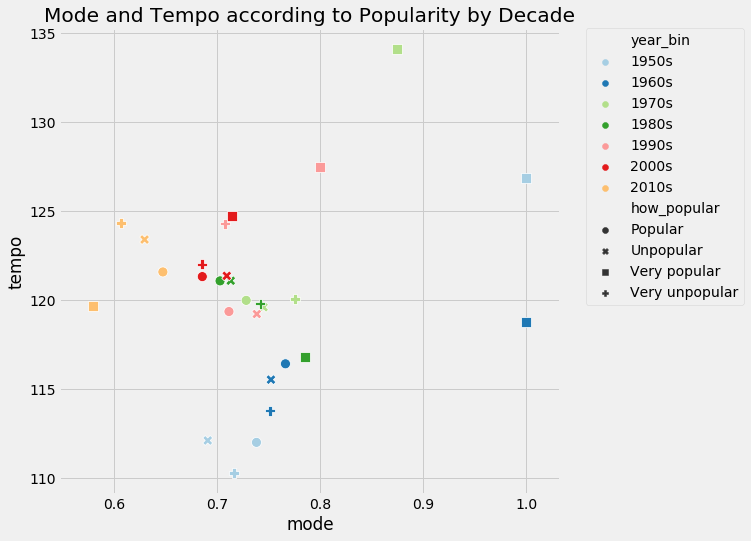

In [33]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

mode = sns.scatterplot(x='mode', y='tempo', hue='year_bin', 
                style='how_popular', palette="Paired",s=100, data=df_decades)
mode.set_title(
    "Mode and Tempo according to Popularity by Decade"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*We see a lot of variation in the relationship between mode and tempo and its popularity depending on the decade. There seems to be heterogenization between the decades and before the 80's amongst the decades. We see more homogenization in the 2000s and 2010s.*

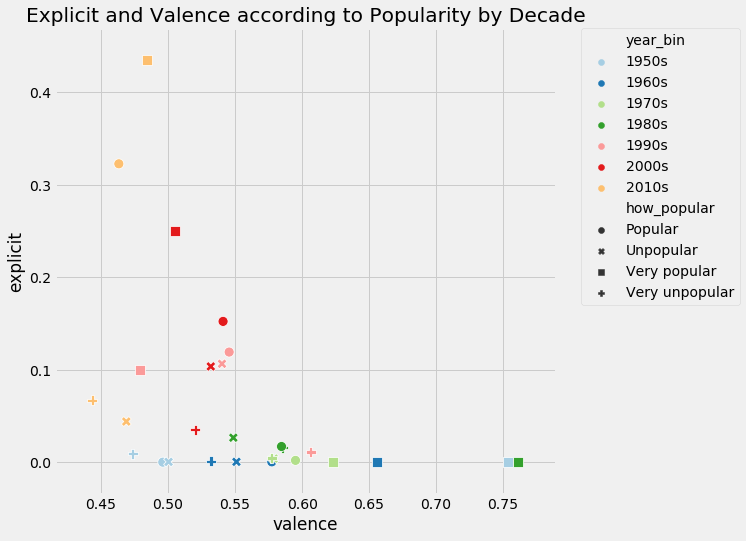

In [34]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

sad = sns.scatterplot(x='valence', y='explicit', hue='year_bin', 
                style='how_popular', palette="Paired",s=100, data=df_decades)
sad.set_title(
    "Explicit and Valence according to Popularity by Decade"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*Today it is more common to have explicit songs than before and with a lower valence as well. We see a trend in the past three decades of more explicit songs with lower valence as opposed to high valence songs that were not explict at all, or were unpopular for being explicit.*

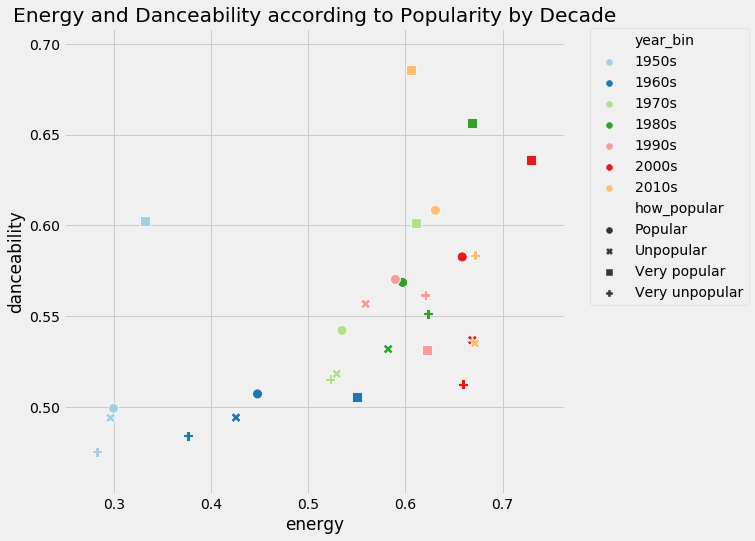

In [35]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

energy = sns.scatterplot(x='energy', y='danceability', hue='year_bin', 
                style='how_popular', palette="Paired", s=100, data=df_decades)
energy.set_title(
    "Energy and Danceability according to Popularity by Decade"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*We can see that for most decades higher `danceability` makes songs more popular than lower danceability. This is true for every decade except for the 1960's and 1990's, whose very popular music seems to have on average lower danceability. The energy levels are positively correlated with danceability, the higher the `energy` the higher the `danceability`. We see that for every decade the higher danceability is associated with higher popularity. We also see an upward trend in the levels of energy from one decade to another.* 

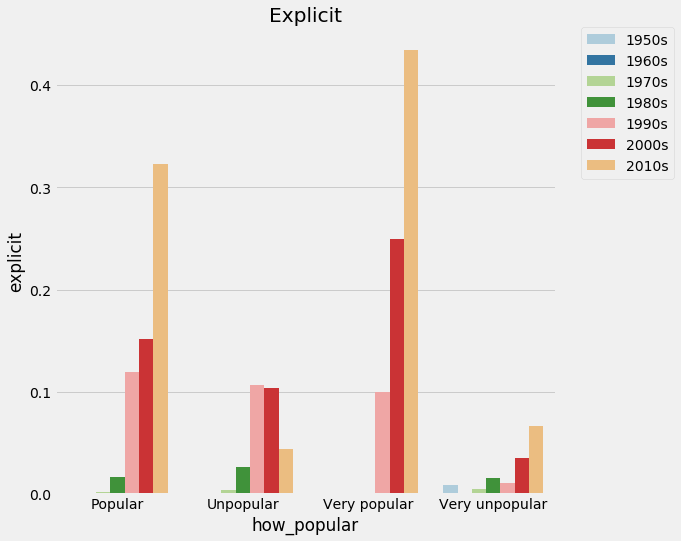

In [36]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

explicit = sns.barplot(x="how_popular", y="explicit", hue="year_bin", palette="Paired", data=df_decades)
explicit.set_title(
    "Explicit"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*Today it is more common to have explicit songs than before, it seems that before the 90's there were very few explicit songs and those that were explicit were very unpopular. Whereas today there are many explicit songs and those that are very popular also seem to be explicit.*

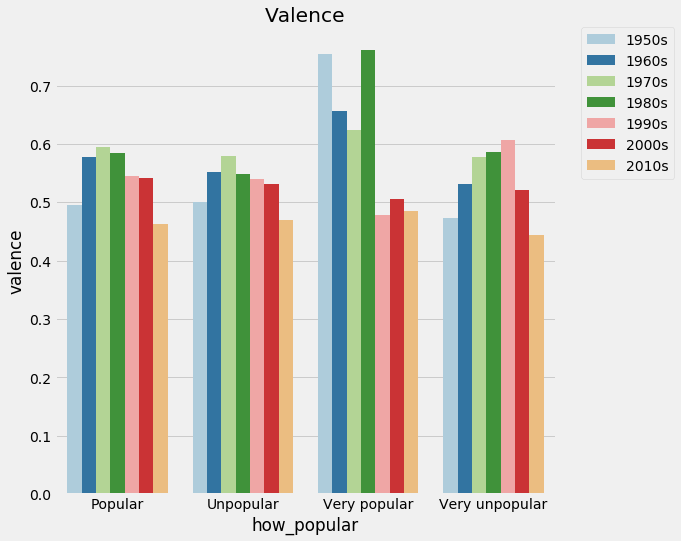

In [37]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

valence = sns.barplot(x="how_popular", y="valence", hue="year_bin", palette="Paired", data=df_decades)
valence.set_title(
    "Valence"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*Lower valence seems to have become more popular after the 80's, we can see a clear shift from a very high valence in the 50's, 60's, 70's and 80's as compared to the other three decades. We see also a difference within decade for the 50's, 60's, and the 80's, where lower valence was very unpopular, an the opposite pattern for the 90's where higher valence was very unpopular. There does not seem to be much difference within a decade for the rest.*  

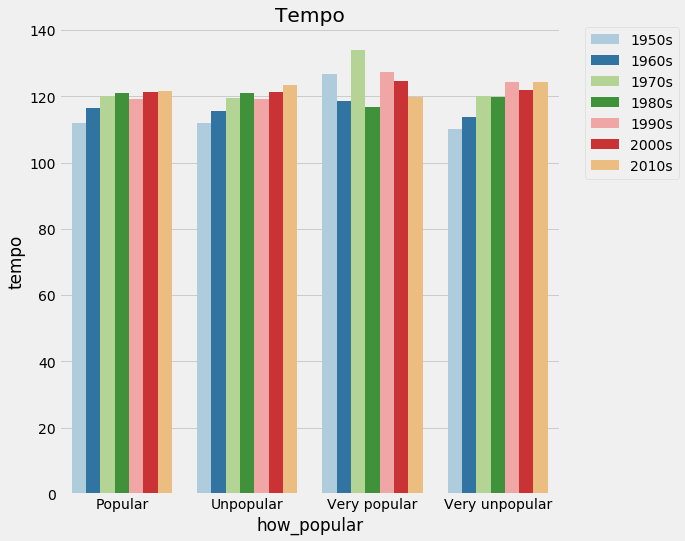

In [38]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

tempo = sns.barplot(x="how_popular", y="tempo", hue="year_bin", palette="Paired", data=df_decades)
tempo.set_title(
    "Tempo"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*The tempo seems to be similar throught the decades and also in the popularity of songs, the only decade that has a larger difference in the tempo is the 1950s.*

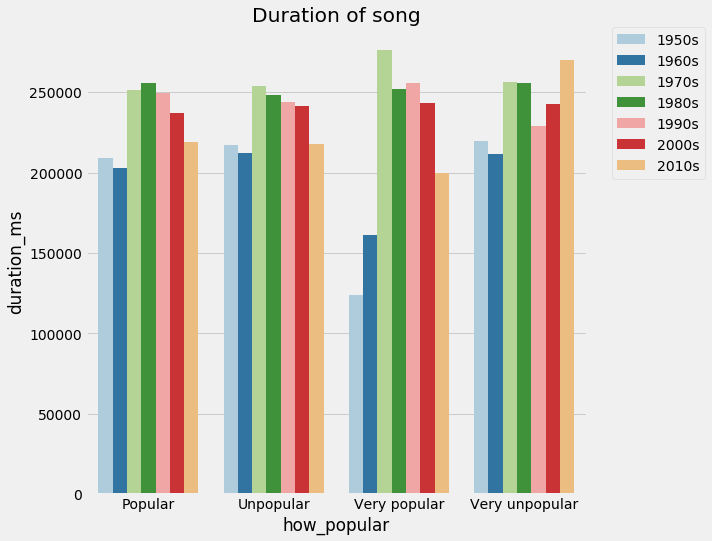

In [39]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

duration = sns.barplot(x="how_popular", y="duration_ms", hue="year_bin", palette="Paired", data=df_decades)
duration.set_title(
    "Duration of song"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

*There is a lot of variation in the duration of the songs from decade to decade and within a decade and the popularity of the song. It seems that shorter songs are more popular in this decade, compared to the 70's, 80's and 90's. But longer than those popular in the 50's and 60's. Now a days it seems that the longer the song the less popular.*

In [71]:
#charly_df = spotify_df.loc[spotify_df.artists == 'Ella Fitzgerald']
#charly_df = spotify_df[spotify_df['artists'] == 'Ella Fitzgerald']
#charly_df


,acousticness,artists,danceability,duration_ms,energy,explicit,uri,instrumentalness,key,liveness,loudness,mode,title,popularity,speechiness,tempo,valence,year


- **Join both data sets using the `uri` from Spotify, remove spotify:track from music_df.**

In [40]:
music_df['uri'] = music_df['uri'].map(lambda x: x.lstrip('spotify:track:'))

In [41]:
popularity_df = spotify_df[['uri', 'popularity', 'how_popular', 'artists', 'explicit']]

In [42]:
music_popularity = pd.merge(music_df, popularity_df, on=["uri"])
music_popularity

,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,...,analysis_url,artist_with_features,year_bin,image,cluster,Gender,popularity,how_popular,artists,explicit
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,Mona Lisa,2.9,...,https://api.spotify.com/v1/audio-analysis/3k5y...,NaN,1950s,https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...,String Lover,male,41,Popular,Nat King Cole,0
1,I was dancing with my darling to the Tennessee...,174.6,0.351,1950,5.2,88.74,138,16,Tennessee Waltz,2.9,...,https://api.spotify.com/v1/audio-analysis/6DKt...,NaN,1950s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female,39,Unpopular,Patti Page,0
2,I was dancing with my darling to the Tennessee...,174.6,0.351,1951,5.2,88.74,138,16,Tennessee Waltz,2.9,...,https://api.spotify.com/v1/audio-analysis/6DKt...,NaN,1950s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female,39,Unpopular,Patti Page,0
3,If ever a devil was born\nWithout a pair of ho...,208.8,0.107,1951,4.0,91.78,160,28,Jezebel,1.7,...,https://api.spotify.com/v1/audio-analysis/6SYQ...,NaN,1950s,https://i.scdn.co/image/c3bbf9fc8bd35a89e42950...,String Lover,male,28,Unpopular,Frankie Laine,0
4,"Tra-la-la, tweedlee dee dee it gives me a thri...",139.5,0.108,1951,5.2,88.74,109,13,Mockin' Bird Hill,2.9,...,https://api.spotify.com/v1/audio-analysis/5yzl...,NaN,1950s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female,36,Unpopular,Patti Page,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,I was scared of dentists and the dark\nI was s...,430.2,0.154,2015,4.8,98.21,363,48,Riptide,1.3,...,https://api.spotify.com/v1/audio-analysis/3Jvr...,NaN,2010s,https://i.scdn.co/image/7d186c3a80955b82a8cc46...,String Lover,male,77,Popular,Vance Joy,0
1701,"Dear future husband,\nHere's a few things\nYou...",458.1,0.221,2015,4.4,90.77,360,59,Dear Future Husband,2.1,...,https://api.spotify.com/v1/audio-analysis/3cU2...,NaN,2010s,https://i.scdn.co/image/c1699dbc49883d51faed18...,Poetic,female,72,Popular,Meghan Trainor,0
1702,I found myself dreaming of\nSilver and gold\nL...,409.5,0.253,2015,4.4,90.77,315,46,Like I'm Gonna Lose You,2.1,...,https://api.spotify.com/v1/audio-analysis/2YlZ...,John Legend,2010s,https://i.scdn.co/image/c1699dbc49883d51faed18...,Poetic,female,79,Popular,Meghan Trainor John Legend,0
1703,Going out tonight\nChanges into something red\...,399.6,0.026,2015,4.0,83.32,296,52,Night Changes,2.9,...,https://api.spotify.com/v1/audio-analysis/5O2P...,NaN,2010s,https://i.scdn.co/image/5bb443424a1ad71603c43d...,String Lover,Group,82,Very popular,One Direction,0


In [43]:
exp_music = music_popularity[music_popularity['explicit']== 1]
exp_music.min()

lyrics              \nAss ass ass ass ass\nAss ass ass ass ass\nAs...
num_syllables                                                    14.4
pos                                                                 0
year                                                             1991
fog_index                                                         3.6
flesch_index                                                     50.5
num_words                                                           8
num_lines                                                           2
title                                                1st Of Tha Month
f_k_grade                                                        -1.1
artist                                                        69 Boyz
difficult_words                                                     3
num_dupes                                                           1
neg                                                                 0
neu                 

In [44]:
exp_music_90 = exp_music[exp_music['year_bin'] =='1990s']['lyrics']
exp_music_00 = exp_music[exp_music['year_bin'] =='2000s']['lyrics']
exp_music_10 = exp_music[exp_music['year_bin'] =='2010s']['lyrics']

In [45]:
exp_text90 = ''.join(exp_music_90)
exp_text00 = ''.join(exp_music_00)
exp_text10 = ''.join(exp_music_10)

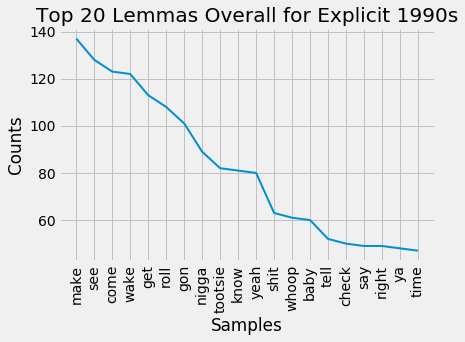

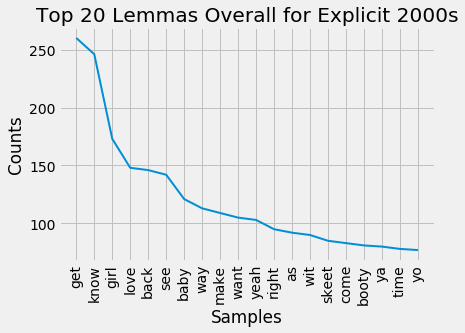

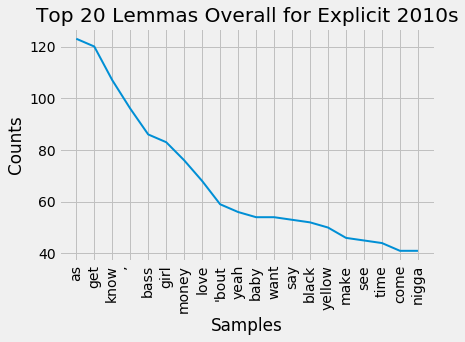

In [46]:
plot_top_lemmas(exp_text90, "Explicit 1990s", n=20)
plot_top_lemmas(exp_text00, "Explicit 2000s", n=20)
plot_top_lemmas(exp_text10, "Explicit 2010s", n=20)

5. Explain in words (300+) how the results of your analysis support (or refute) your theory from (2). What do you conclude?

*The results from my analysis support my theory proposed. I must recognize my limitations, my larger data frame does not include lyrics like the music.csv, and therefore I cannot analyze the lyrics. It is also important to recognize that the measure of popularity is defined on a scale of 0 to 100 and the scaling process is unknown so there might be errors in the measurement of this variable.  But the Spotify data frame has many more observations which lead to a larger sample, and there for less bias towards a specific composition of music, or “pop” music. When analyzing the averages by decade we see that on average the tempo does not vary a lot from decade to decade, but other sound metrics like tempo and mode together do. What I found more significant was the analysis of the valence, which seems to have changed significantly during the past 30 years. It seems as if lower valence, or slower, less upbeat or “happy” songs are more popular now a days than before. There seems to be a shift in the mood of the younger generations, compared to older generations that seem to enjoy more upbeat or “happier” songs. This is also notorious in the use of explicit words, or a change in the lyrics of the songs as predicted. The use of explicit lyrics was not even present in the Billboard 100 until the 1990’s. Not only has the quantity of songs using explicit songs increased over the years, but the popularity of songs that are explicit as well, it seems that the relationship between explicit songs and popularity is inverted since the 90’s. Before the more explicit the song the less popular, and now a days it is the opposite. This is a shift that happened in the 1990’s just like the increased popularity of lower valence songs. We see a similar trend in the 1960’s, low valance songs were popular. If we think about the panorama during these decades there has been wars, economic crisis and in general a shift towards being more critical about the political and social changes. Whereas the 1950’s, 1970’s and 1980’s see to be more cheerful, energetic, and dance songs, that could be related to more prosperous times economically, or to times of more stability. It would interesting to conduct a further analysis of the cultural panorama and the trends in music. From this analysis I conclude that in music, like in every art form, we will find both homogeneity and heterogeneity, since it is impossible to create something completely new, specially when there is a sound metric to use when composing music. But that the heterogeneity of the music through time will be more in the relationship between the lyrics and the sound parameters, and how these interact to “create stress” in individuals and in society to accurately reflect the cultural identity of the time.*  